# Сентимент-анализ отзывов на товары

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis-light

Классифицируйте отзывы по тональности

In [1]:
import re
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

Читаем данные

In [2]:
train = pd.read_csv("data/products_sentiment_train.tsv", sep='\t')
test = pd.read_csv("data/products_sentiment_test.tsv", sep='\t')

In [3]:
train.head()

,text,grade
0,"take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [4]:
test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


Каков размер

In [5]:
print('Size of train:', train.shape[0])
print('Size of test:', test.shape[0])

Size of train: 2000
Size of test: 500


Сравним количество позитивных и негативных

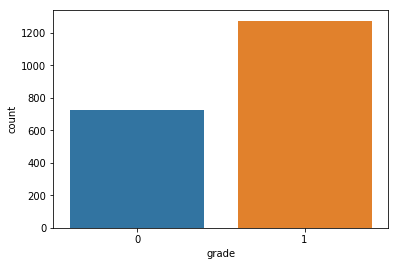

In [6]:
sb.countplot(x='grade', data=train)

Видим, что есть перекос в сторону позитивных отзывов

Создадим общий список отзывов

In [7]:
reviews = pd.concat([train, test], axis=0)

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(reviews['text'])
X_train_vect = vectorizer.transform(train['text'])
X_test_vect = vectorizer.transform(test['text'])
X_train_vect.shape

(2000, 4488)

Количество уникальных слов (фич)

In [9]:
quantity_of_features = len(vectorizer.get_feature_names())
print(quantity_of_features)

4488


Отделим "ответы" от текстов

In [10]:
y = train['grade']

Запустим простую регрессию

In [11]:
log_reg = LogisticRegression(C=1)
results = cross_val_score(log_reg, X_train_vect, y, cv=3)
print(results)

[0.7916042  0.74212894 0.78828829]


In [12]:
def save_result(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 500)),"y":prediction}).to_csv(file_name, index=False, header=True)
log_reg.fit(X_train_vect, y)
save_result(log_reg.predict(X_test_vect), 'result.csv')

В общем этой херней мы построили бейзлайн. Давайте его ломать

In [13]:
train_split, test_split, y_train_split, y_test_split = train_test_split(X_train_vect, y, 
                                                                        test_size=0.25, random_state=42)

In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Using TensorFlow backend.


Build model...


In [15]:
history = model.fit(train_split, y_train_split, epochs=100,
                    validation_data=(test_split, y_test_split))

Train on 1500 samples, validate on 500 samples
Epoch 1/100
 320/1500 [=====>........................] - ETA: 4:43 - loss: 0.6771 - acc: 0.5844

KeyboardInterrupt: 

In [146]:
loss, accuracy = model.evaluate(test_split, y_test_split, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_split, y_test_split, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7560
Testing Accuracy:  0.7560


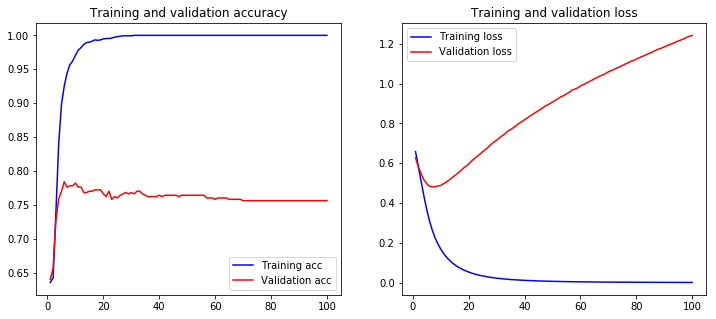

In [147]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

ШТОШ. Перейдем к тяжелой артиллерии

In [160]:
train_split, test_split, y_train_split, y_test_split = train_test_split(np.array(train['text']), y, 
                                                                        test_size=0.25, random_state=42)

In [161]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_split)

X_train = tokenizer.texts_to_sequences(train_split)
X_test = tokenizer.texts_to_sequences(test_split)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_split[2])
print(X_train[2])

2 . battery life is over 4.5 hours , compared to about 2.5 hours for the g2 or the 2 hours for most nikons . 
[115, 45, 119, 7, 129, 150, 142, 154, 428, 4, 51, 115, 142, 154, 12, 1, 928, 40, 1, 115, 154, 12, 102, 1657]


In [163]:
for word in ['the', 'all', 'happy', 'bad']: print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
happy: 199
bad: 427


In [164]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  9  35   7 297   8  60  32 327   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [169]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           169250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 11        
Total params: 169,771
Trainable params: 169,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7800


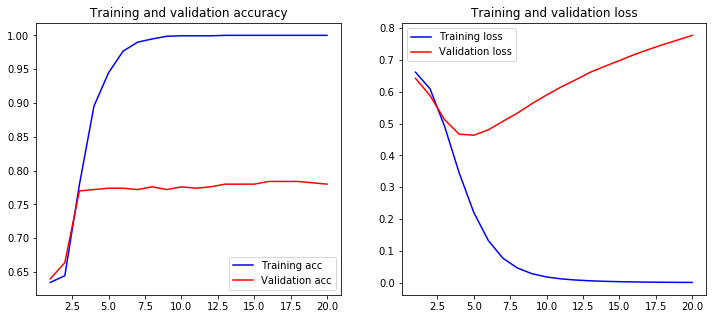

In [170]:
history = model.fit(X_train, y_train_split,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test_split),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_split, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_split, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
prediction = np.around(model.predict(X_test_vect), decimals=0)
save_result(prediction[:,0].astype(int), 'result_nn.csv')